# PHYS247-HW4
Steven Mills

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

import datetime as dt

### a) data cleaning

   loan_amnt  term  int_rate  installment  grade  sub_grade  home_ownership  \
0      10000   0.0     11.44       329.48    1.0        8.0             3.0   
1       8000   0.0     11.99       265.68    1.0        9.0             0.0   
2      15600   0.0     10.49       506.97    1.0        7.0             3.0   
3       7200   0.0      6.49       220.65    0.0        1.0             3.0   
4      24375   1.0     17.27       609.33    2.0       14.0             0.0   

   annual_inc  verification_status  loan_status  ...  open_acc  pub_rec  \
0    117000.0                  0.0          1.0  ...        16        0   
1     65000.0                  0.0          1.0  ...        17        0   
2     43057.0                  1.0          1.0  ...        13        0   
3     54000.0                  0.0          1.0  ...         6        0   
4     55000.0                  2.0          0.0  ...        13        0   

   revol_bal  revol_util  total_acc  initial_list_status  application_type

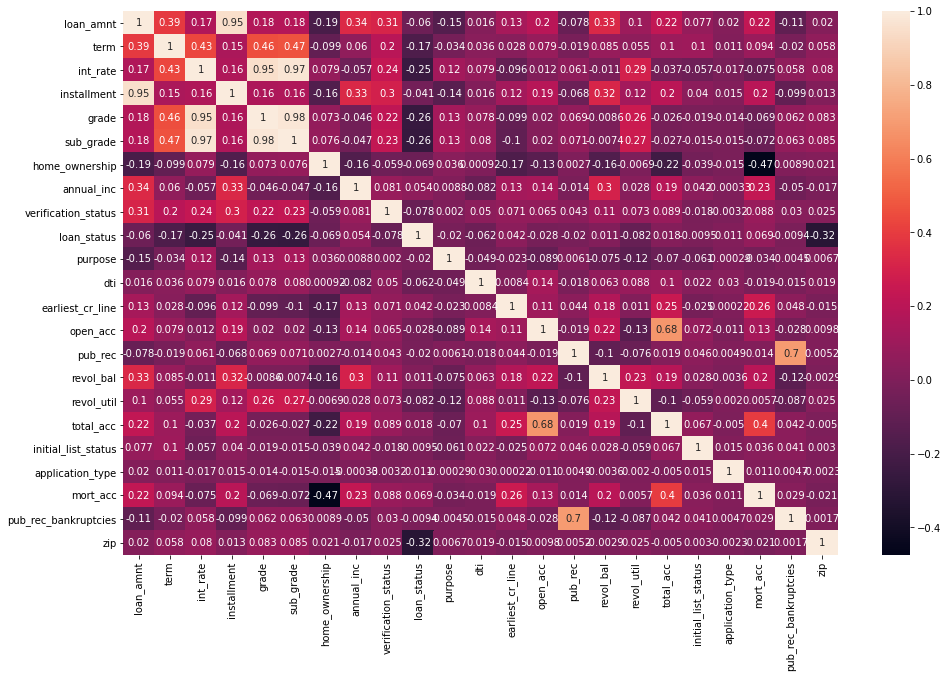

dropping features ['installment', 'grade', 'sub_grade', 'total_acc', 'pub_rec_bankruptcies']
   loan_amnt  term  int_rate  home_ownership  annual_inc  verification_status  \
0      10000   0.0     11.44             3.0    117000.0                  0.0   
1       8000   0.0     11.99             0.0     65000.0                  0.0   
2      15600   0.0     10.49             3.0     43057.0                  1.0   
3       7200   0.0      6.49             3.0     54000.0                  0.0   
4      24375   1.0     17.27             0.0     55000.0                  2.0   

   loan_status  purpose    dti  earliest_cr_line  open_acc  pub_rec  \
0          1.0     12.0  26.24             10958        16        0   
1          1.0      2.0  22.05              5814        17        0   
2          1.0      1.0  12.79              4688        13        0   
3          1.0      1.0   2.60              5022         6        0   
4          0.0      1.0  33.95              7763        13       

In [2]:
df = pd.read_csv('LendingClub.csv')

##########  BASIC CLEANING ##########

# change term to simply number of months
df['term'] = df['term'].apply(lambda x: np.int8(x.split()[0]))

# combine home_ownership 'OTHER' -> [OWN, RENT, OTHER]
df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

# convert earliest acc to number of days ago
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: (dt.datetime.today() - dt.datetime.strptime(x, '%b-%y')).days)

# replace address with zip code
df['zip'] = [q.split()[-1] for q in df['address']]

# change earliest_cr_line to unix epoch time
df.drop(labels=['address'], axis=1, inplace=True)


##########  ENCODE CATEGORICAL DATA ##########

def encode_cats(df):
    ocats = [ # ordinal
        'grade',
        'sub_grade',
        'initial_list_status',       
        'term',
        'home_ownership',
        'loan_status',
        'purpose',
        'application_type',
        'zip',
        'verification_status'
    ]
    hcats = [ # one-hot < -- one-hot made result much worse, not sure why
    ]
    enc = OrdinalEncoder()
    for cat in ocats:
        df[cat] = enc.fit_transform(np.array(df[cat]).reshape(-1, 1))

    enc = OneHotEncoder()
    for cat in hcats:
        df[cat] = enc.fit_transform(np.array(df[cat]).reshape(-1, 1)).toarray()
    return df

df = encode_cats(df)
print(df.head())


########## DROP CORRELATED FEATURES ##########

plt.figure(figsize=(16,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

threshold = 0.5
corr_matrix = df.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
dropl = [column for column in upper.columns if any(upper[column] > threshold)]
print('dropping features', dropl)
df.drop(df[dropl], axis=1, inplace=True)
print(df.head())

########## CHANGE TAIL-HEAVY FEATURES TO LOG SCALE ##########
df['annual_inc'] = df['annual_inc'].apply(lambda x:  np.log10(x+1))
df['revol_bal'] = df['revol_bal'].apply(lambda x:  np.log10(x+1))
print(df.head())

### b) partition data into test, train sets

In [3]:
X = df.drop(columns=['loan_status'], axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=1337)

normailze the data

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### c) build sequential model

In [5]:
model=Sequential(name='lending')

#### INPUT LAYER ####
model.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu', name='input'))

#### HIDDEN LAYER 1 ####
model.add(Dropout(0.15, name='dropout_1'))
model.add(Dense(20, activation='relu', name='hidden_1'))

#### HIDDEN LAYER 2 ####
model.add(Dropout(0.15, name='dropout_2'))
model.add(Dense(12, activation='relu', name='hidden_2'))

#### OUTPUT LAYER ####
#model.add(Dropout(0., name='dropout_3'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=32, epochs=6)

Epoch 1/6
8646/8646 [==============================] - 7s 867us/step - loss: 0.3861 - accuracy: 0.8396 - val_loss: 0.3278 - val_accuracy: 0.8590
Epoch 2/6
8646/8646 [==============================] - 8s 893us/step - loss: 0.3180 - accuracy: 0.8700 - val_loss: 0.2887 - val_accuracy: 0.8857
Epoch 3/6
8646/8646 [==============================] - 8s 879us/step - loss: 0.2931 - accuracy: 0.8816 - val_loss: 0.2757 - val_accuracy: 0.8876
Epoch 4/6
8646/8646 [==============================] - 8s 886us/step - loss: 0.2873 - accuracy: 0.8825 - val_loss: 0.2722 - val_accuracy: 0.8883
Epoch 5/6
8646/8646 [==============================] - 7s 865us/step - loss: 0.2841 - accuracy: 0.8829 - val_loss: 0.2684 - val_accuracy: 0.8885
Epoch 6/6
8646/8646 [==============================] - 8s 902us/step - loss: 0.2813 - accuracy: 0.8832 - val_loss: 0.2660 - val_accuracy: 0.8884


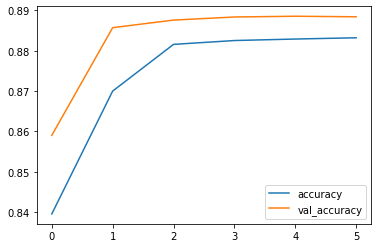

In [6]:
history = pd.DataFrame(model.history.history)
history[['accuracy','val_accuracy']].plot()

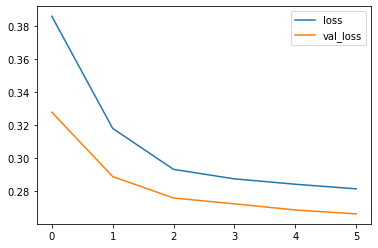

In [7]:
history = pd.DataFrame(model.history.history)
history[['loss','val_loss']].plot()

### d) evaluate performance

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

h = model.predict(X_test)
y_prediction = np.array([0. if q < 0.5 else 1. for q in h]) # Charged Off = 0.0, Fully Paid = 1.0

print("The Test Accuracy of the model is: {:.3f} %".format(accuracy_score(y_test, y_prediction) * 100.))
print()

print("Confusion Matrix [[TP, FP], [FN, TN]]")
print(confusion_matrix(y_test, y_prediction))
print()

target_names = ['Fully Paid', 'Charged Off']
print(classification_report(y_test, y_prediction, target_names=target_names))

The Test Accuracy of the model is: 88.839 %

Confusion Matrix [[TP, FP], [FN, TN]]
[[10105 13165]
 [   68 95228]]

              precision    recall  f1-score   support

  Fully Paid       0.99      0.43      0.60     23270
 Charged Off       0.88      1.00      0.94     95296

    accuracy                           0.89    118566
   macro avg       0.94      0.72      0.77    118566
weighted avg       0.90      0.89      0.87    118566



In [9]:
true_paid = [X_test[i] for i in range(y_test.size) if y_test[i] == 1. and y_prediction[i] == 1.]
false_paid = [X_test[i] for i in range(y_test.size) if y_test[i] == 0. and y_prediction[i] == 1.]
true_charge = [X_test[i] for i in range(y_test.size) if y_test[i] == 0. and y_prediction[i] == 0.]
false_charge = [X_test[i] for i in range(y_test.size) if y_test[i] == 1. and y_prediction[i] == 0.]

print('sanity check:')
print('    total loans in test set                   ', len(X_test))
pct_filtered = (np.float(len(true_charge))/np.float(len(X_test)))*100.
pct_not_filtered = (np.float(len(false_paid))/np.float(len(X_test)))*100.
print('    loans predicted to charge off (filtered)  ', len(true_charge), ' {:.3f} %'.format(pct_filtered))
print('    loans NOT predicted to charge off (should have been filtered)  ', len(true_charge), ' {:.3f} %'.format(pct_not_filtered))
#print('    expect chargeoff(0), predict paid(1)      ', len(false_paid), '\tfalse positive, FP')
#print('    expect paid(1), predict chargeoff(0)        ', len(false_charge), '\tfalse negative, FN')

sanity check:
    total loans in test set                    118566
    loans predicted to charge off (filtered)   10105  8.523 %
    loans NOT predicted to charge off (should have been filtered)   10105  11.104 %


### Conclusions  
Without using any prediction model, 20% of loans will result in Charge Off status.  
Using this ANN, we reduced the charge off to 11.1%.  
There were a small number of false negatives, which result in loss of earnings, but the savings will far outweighs this loss.  
  
Note about NN training:  most likely a grid search is necessary to tune "hyperparameters" in order to optimize NN performance. Manual tuning is time consuming and error prone.

